# The effect of COVID-19 on deliveredKwh
We designed a machine learning-based model (Neural Network-based) that to predict the value of "dailyDeleivered". 

We monitored the prediction error of the pre and post COVID data to observe the effect of COVID-19 on the prediction error. 
We also observed the sign of the prediction error to see whether the predicted dailyDelivered values are greater or less than the actula values.
The following code and results are for a dataset that contains data of residential premises.



In [61]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
#from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,SimpleRNN
from datetime import date
from dateutil import parser
print(tf.__version__)

2.4.1


In [62]:
def temporalize(arr,win_size,step_size,features,add_index=0):
  """
  arr: any 2D array whose columns are distinct variables and 
    rows are data records at some timestamp t
  win_size: size of data window (given in data points)
  step_size: size of window step (given in data point)
  
  Note that step_size is related to window overlap (overlap = win_size - step_size), in 
  case you think in overlaps."""
  #
  dataFrameTimeseries=pd.DataFrame()
  #
  w_list = list()
  n_records = arr.shape[0]
  remainder = (n_records - win_size) % step_size 
  num_windows = 1 + int((n_records - win_size - remainder) / step_size)
  for k in range(num_windows):
    w_list.append(arr[k*step_size:win_size-1+k*step_size+1])
    #
    #convert the matrix to data frame
    dataFrameTemp=pd.DataFrame(data=arr[k*step_size:win_size-1+k*step_size+1], columns=features)
    dataFrameTemp["timeseriesId"]=k+add_index
    dataFrameTimeseries=pd.concat([dataFrameTimeseries,dataFrameTemp])
    #
  return np.array(w_list),dataFrameTimeseries

In [63]:
def is_number(s):
        try:
            float(s)
            return True
        except ValueError:
            pass
        
        try:
            import unicodedata
            unicodedata.numeric(s)
            return True
        except (TypeError, ValueError):
            pass
        return False 

In [64]:
def changeDates(dateList):
    daysList = []
    firstDate = parser.parse(dateList[0])
    for date in dateList:
        dateObject = parser.parse(date) - firstDate
        #daysList.append(dateObject.timetuple().tm_yday)
        daysList.append(dateObject.days)
    
    return daysList

In [65]:
def plot_(modelName,h_axis,v1_axis,v2_axis, title="Daily Delivered (kWh)"):
    h_axis = changeDates(h_axis)
    plt.rcParams.update({'font.size': 15})
    plt.tight_layout()
    plt.figure(figsize=(30,6))
    plt.plot(h_axis, v2_axis, label="predictedLoad")
    plt.plot(h_axis, v1_axis, label="dailyDelivered")
    plt.ylim(top = max(max(v1_axis), max(v2_axis)) + 0.3)
    plt.legend(loc="upper right")
    plt.title(title)
    plt.xlabel("Local Days")
    plt.savefig(modelName+".png", facecolor='white', transparent=False)

In [66]:
# split into train and test sets
def split_(dataset, train_size=0.67, dimension=2):
    #train_size = int(len(dataset) * train_size)
    train_size = 365
    test_size = len(dataset) - train_size
    train=[]
    test=[]
    if dimension==1:
        train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    else:
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return train,test

In [67]:
def neuralnet_(modelName,X,Y,trainig_percentage=0.76):
    model = Sequential()

    # The Input Layer :
    model.add(Dense(16, kernel_initializer='normal',input_dim=X.shape[1], activation='relu'))

    # The Hidden Layers :
    model.add(Dense(32, kernel_initializer='normal',activation='relu'))
    model.add(Dense(64, kernel_initializer='normal',activation='relu'))
    model.add(Dense(64, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    #train on precovid data and test on all dataset
    Xtrain,Xtest=split_(X,trainig_percentage)
    Ytrain,Ytest=split_(Y,trainig_percentage,1)
    
    model.fit(Xtrain, Ytrain, epochs=500)
    
    #prediction error on pre-covid data (training data)
    yhat1=model.predict(Xtrain)
    
    prediction_error1=np.square(Ytrain-yhat1).mean(axis=None).ravel()
    print("prediction error on pre-covid data")
    print("**********************************")
    print(prediction_error1)
    
    #prediction error on post-covid data (testing data)
    yhat2 = model.predict(Xtest)
    prediction_error2=np.square(Ytest-yhat2).mean(axis=None).ravel()
    print("prediction error on post-covid data")
    print("**********************************")
    print(prediction_error2)
    
    print("Error sign (actual-prediction) for post covid data: If Positive--> actual is greater than predicted")
    print("**********************************")
    print((Ytest-yhat2).mean(axis=None))
    
    #predict the entire data
    yhat=model.predict(X)

    h_axis=dataset["time"]
    v1_axis=dataset["dailyDelivered"]
    v2_axis=yhat.flatten()
#     temp=np.zeros(win_size)
#     v2_axis=np.concatenate([temp,v2_axis])
    plot_(modelName,h_axis,v1_axis,v2_axis)
    

In [68]:
#set window sizes and their overlap
win_size=10
overlap=win_size-1

#read data
dataset = pd.read_csv('../ProcessedData/processed_Class-res', engine='python')

#preprocess data
dataset=dataset.fillna(-1)


for column in dataset.columns:
    if is_number(dataset.iloc[1][column]) and column!="id":
        min_max=MinMaxScaler(feature_range=(0, 1))
        dataset[[column]]=min_max.fit_transform(dataset[[column]])
       
#set variables based on the data attributes    
n_features=len(dataset.columns.values)
dailyDeliveredIndex=np.where(dataset.columns.values=="dailyDelivered")
dailyDeliveredIndex=dailyDeliveredIndex[0][0]

X_ = dataset[["id", "Temp", "isWeekend"]].values
y_ = dataset[["id", "dailyDelivered"]].values



In [69]:
y_.shape[1]

2

**********Model3: LSTM-Autoencoder*******************************
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_31 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_32 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
12/12 [==============================] -

<Figure size 432x288 with 0 Axes>

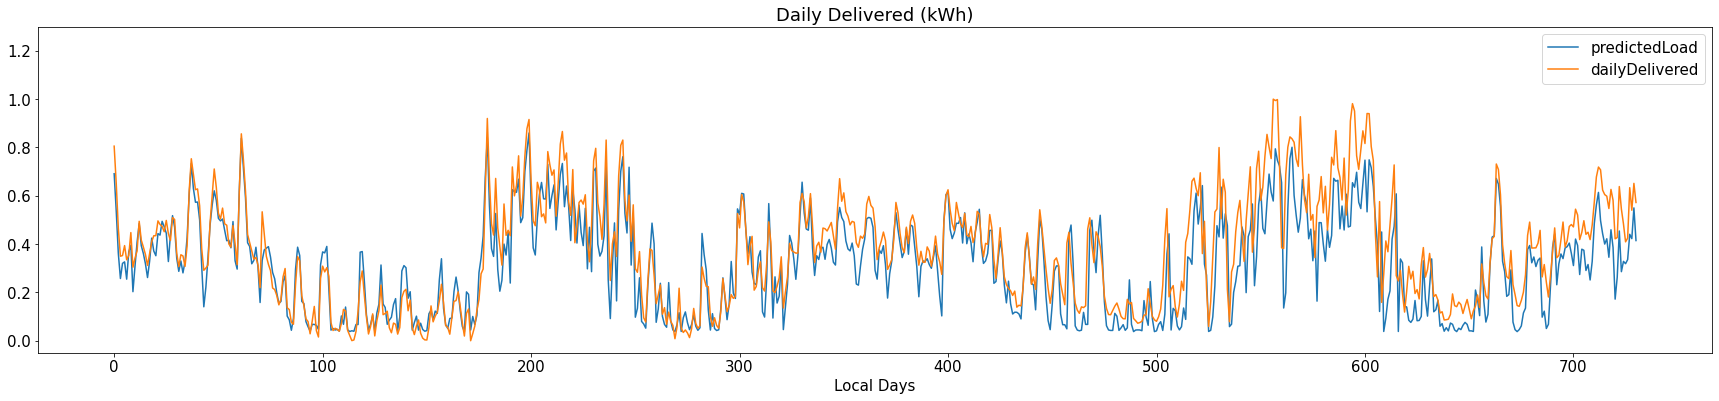

In [70]:
#model3:
print("**********Model3: LSTM-Autoencoder*******************************")
neuralnet_("NeuralNetwork-Model3",X_[:,1:], y_[:,1:])